In [3]:
#Initialize some stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import UCSmpl

# Function for data cleaning PUDL. Sums capacity by year using the date in the
# indicated column.
def annual_totals(df, date_field = 'report_date'):

    # Convert 'report_date' to datetime and extract year
    df[date_field] = pd.to_datetime(df[date_field])
    df['year'] = df[date_field].dt.year

    # Delete empty rows
    df = df.loc[df['capacity_mw'] != 0]

    # Group by 'report_year' and calculate total capacity
    result = df.groupby('year')['capacity_mw'].sum().reset_index()

    return result

In [4]:
## Pull in the raw DG data from PUDL

# Distributed generation is spread across three datasets, each showing total
# online capacity per year (i.e. does not track additions and retirements)

# Pre-2016 DG
dg_raw_url = (f"https://data.catalyst.coop/pudl/"
        f"core_eia861__yearly_distributed_generation_tech.csv?"
        f"_labels=on&_stream=on&_size=max")

dg_raw = pd.read_csv(dg_raw_url)

# Net-metering data
nm_raw_url = (f"https://data.catalyst.coop/pudl/"
        f"core_eia861__yearly_net_metering_customer_fuel_class.csv?"
        f"_labels=on&_stream=on&_size=max")

nm_raw = pd.read_csv(nm_raw_url)

# Non-net metering data
nnm_raw_url = (f"https://data.catalyst.coop/pudl/"
        f"core_eia861__yearly_non_net_metering_customer_fuel_class.csv?"
        f"_labels=on&_stream=on&_size=max")

nnm_raw = pd.read_csv(nnm_raw_url)

In [5]:
# Clean and combine the data

dg = annual_totals(dg_raw)
nm = annual_totals(nm_raw)
nnm = annual_totals(nnm_raw)

df_distributed = pd.concat([dg, nm, nnm])

# Group by 'year' and sum the 'capacity' values. This df now has annual online capacity
df_distributed = df_distributed.groupby('year', as_index=False)['capacity_mw'].sum()

# Rename capacity
df_distributed = df_distributed.rename(columns={'capacity_mw': 'dg_capacity_mw'})

In [6]:
## Download the centralized generation data
central_raw_url = (f"https://data.catalyst.coop/pudl/"
        f"out_eia__yearly_generators.csv?"
        f"_labels=on&_stream=on&generator_operating_date__notblank=1&"
        f"report_date__gte=2024-01-01&_size=max")

central_raw = pd.read_csv(central_raw_url)

C:\Users\lShaver\AppData\Local\Temp\ipykernel_20672\3720556461.py:7: DtypeWarning: Columns (17,21,35,72,81,93) have mixed types. Specify dtype option on import or set low_memory=False.
  central_raw = pd.read_csv(central_raw_url)


In [7]:
# Clean up the data and add some columns
additions = annual_totals(central_raw, "generator_operating_date")
retirements = annual_totals(central_raw, "generator_retirement_date")

additions = additions.rename(columns={'capacity_mw': 'additions_mw'})
retirements = retirements.rename(columns={'capacity_mw': 'retirements_mw'})

df_central = pd.merge(additions, retirements, on='year', how='outer').fillna(0)
df_central['net_change_mw'] = df_central['additions_mw'] - df_central['retirements_mw']
df_central['central_mw'] = df_central['net_change_mw'].cumsum()

# Combine the two data sets to plot
df_combined = pd.merge(df_distributed, df_central, on='year', how='outer').fillna(0)

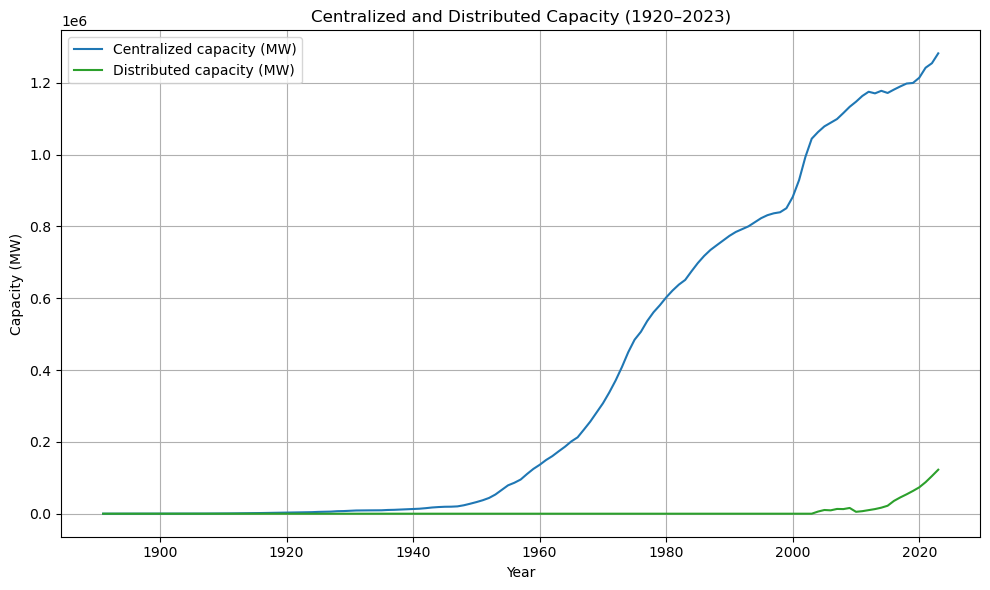

In [8]:
# Basic plot

# Filter for years
df_plot = df_combined[(df_combined['year'] >= 1891) & (df_combined['year'] <= 2023)]

plt.figure(figsize=(10, 6))

plt.plot(df_plot['year'], df_plot['central_mw'], label='Centralized capacity (MW)', color='tab:blue')
plt.plot(df_plot['year'], df_plot['dg_capacity_mw'], label='Distributed capacity (MW)', color='tab:green')

plt.xlabel('Year')
plt.ylabel('Capacity (MW)')
plt.title('Centralized and Distributed Capacity (1920–2023)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

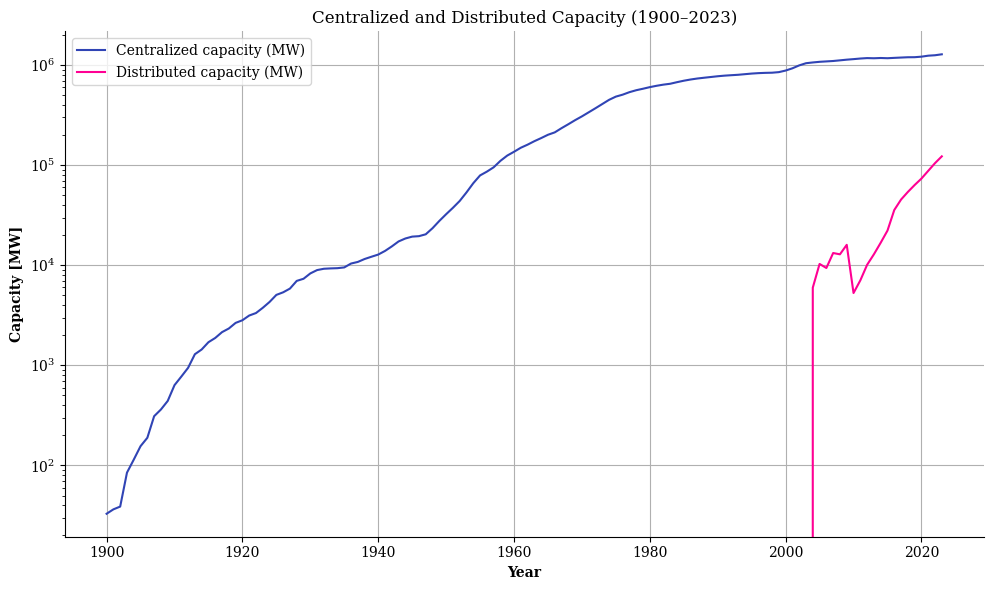

In [15]:
# Log scale plot

# Filter for years
start_year = 1900
df_plot = df_combined[(df_combined['year'] >= start_year) & (df_combined['year'] <= 2023)]

with plt.style.context('ucs_light'):
    plt.figure(figsize=(10, 6))    
    plt.plot(df_plot['year'], df_plot['central_mw'], label='Centralized capacity (MW)')
    plt.plot(df_plot['year'], df_plot['dg_capacity_mw'], label='Distributed capacity (MW)')
    plt.xlabel('Year')
    plt.ylabel('Capacity [MW]')
    plt.title(f"Centralized and Distributed Capacity ({start_year}–2023)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.yscale('log')
    plt.savefig('log-scale.png', dpi=100)
    plt.show()

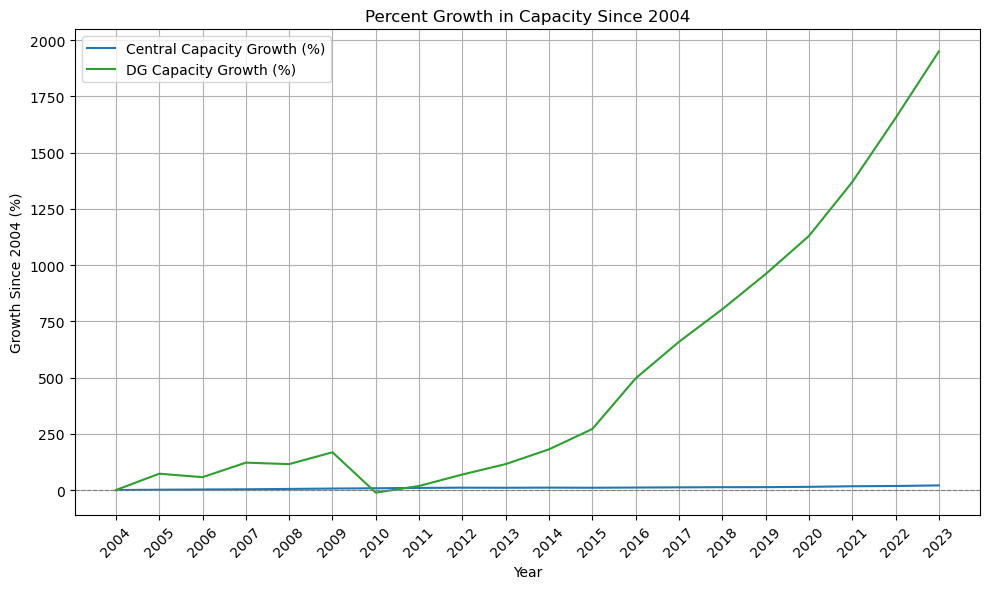

In [13]:
# Percent change plot

base_year = 2004

# Your existing filtered dataframe
df_plot = df_combined[(df_combined['year'] >= base_year) & (df_combined['year'] <= 2023)].copy()

# Get 2005 base values
base_central = df_plot.loc[df_plot['year'] == base_year, 'central_mw'].values[0]
base_dg = df_plot.loc[df_plot['year'] == base_year, 'dg_capacity_mw'].values[0]
if base_dg == 0:
  base_dg = 1

# Calculate percent growth from base year
df_plot['central_growth_pct'] = ((df_plot['central_mw'] - base_central) / base_central) * 100
df_plot['dg_growth_pct'] = ((df_plot['dg_capacity_mw'] - base_dg) / base_dg) * 100

# Plot
plt.figure(figsize=(10, 6))

plt.plot(df_plot['year'], df_plot['central_growth_pct'], label='Central Capacity Growth (%)', color='tab:blue')
plt.plot(df_plot['year'], df_plot['dg_growth_pct'], label='DG Capacity Growth (%)', color='tab:green')

# Fix x-axis: show only whole years
years = df_plot['year'].astype(int)
plt.xticks(ticks=years, labels=years, rotation=45)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Year')
plt.ylabel(f"Growth Since {base_year} (%)")
plt.title(f"Percent Growth in Capacity Since {base_year}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()